## Homework 8 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 25 April, 2025

In [1]:
# Glorious import statements
import numpy as np
import corner
import emcee
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize as opt
from scipy.optimize import minimize
from scipy.stats import chi2, poisson

### Problem 1 : Detailed Balance and the Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is based on the transition probability:

$$ p(x_t, x_{t+1}) = p(x_t | D) {p(x_{t+1} | x_t)}= p(x_t | D) \, {q(x_{t+1} | x_t)} \, {\alpha(x_t, x_{t+1})}$$

where the acceptance probability is defined by

$$
\alpha(x_t, x_{t+1}) = \min \left\{ 1, \frac{p(x_{t+1} | D)}{p(x_t | D)} \cdot \frac{q(x_t | x_{t+1})}{q(x_{t+1} | x_t)} \right\}
$$

We wish to show that the Metropolis-Hastings algorithm obeys the principle of detailed balance, that is, prove:

$$
p(x_t | D) \, p(x_{t+1} | x_t) = p(x_{t+1} | D) \, p(x_t | x_{t+1})
$$
---
We begin by noting that  $p(x_{t+1} | x_t) = q(x_{t+1} | x_t) \, \alpha(x_t, x_{t+1})$ is the transition kernel of the Markov chain. Then, we have two cases, the case for which $\frac{p(x_{t+1} | D)}{p(x_t | D)} \cdot \frac{q(x_t | x_{t+1})}{q(x_{t+1} | x_t)} \leq 1$ and the case where it is more than 1. So, for the first case, we have that the acceptance probability is:

$$
\alpha(x_t, x_{t+1}) = \frac{p(x_{t+1} | D)}{p(x_t | D)} \cdot \frac{q(x_t | x_{t+1})}{q(x_{t+1} | x_t)}.
$$

Therefore,

$$
\begin{aligned}
p(x_t | D) \, p(x_{t+1} | x_t)
&= p(x_t | D) \, q(x_{t+1} | x_t) \, \alpha(x_t, x_{t+1}) \\
&= p(x_t | D) \, q(x_{t+1} | x_t) \cdot \frac{p(x_{t+1} | D)}{p(x_t | D)} \cdot \frac{q(x_t | x_{t+1})}{q(x_{t+1} | x_t)} \\
&= p(x_{t+1} | D) \, q(x_t | x_{t+1}) \\
&= p(x_{t+1} | D) \, \alpha(x_{t+1}, x_t) \, q(x_t | x_{t+1}) \\
&= p(x_{t+1} | D) \, p(x_t | x_{t+1}).
\end{aligned}
$$

For the second case now, se have that $\alpha(x_t, x_{t+1}) = 1$. So, 


$$
\begin{aligned}
p(x_t | D) \, p(x_{t+1} | x_t)
&= p(x_t | D) \, q(x_{t+1} | x_t) \cdot 1 \\
&= p(x_t | D) \, q(x_{t+1} | x_t),
\end{aligned}
$$

and so

$$
\begin{aligned}
p(x_{t+1} | D) \, p(x_t | x_{t+1})
&= p(x_{t+1} | D) \, q(x_t | x_{t+1}) \, \alpha(x_{t+1}, x_t) \\
&= p(x_{t+1} | D) \, q(x_t | x_{t+1}) \cdot \frac{p(x_t | D)}{p(x_{t+1} | D)} \cdot \frac{q(x_{t+1} | x_t)}{q(x_t | x_{t+1})} \\
&= p(x_t | D) \, q(x_{t+1} | x_t).
\end{aligned}
$$
as desired.

### Problem 2 : Boltzmann's Constant and Avogadro's Number

In 1908 Jean Baptiste Perrin measured Boltzmann’s constant $k_B$ in an experiment based on Brownian motion. The experiment was conducted by observing particles of mastic, a substance used in varnish, suspended in water. The particles were spheres of radius $r = 0.52 \, \mu\text{m}$ and had a density of $1.063 \, \text{g}/\text{cm}^3$. By viewing the particles through a microscope, only those in a layer approximately $1 \, \mu\text{m}$ thick were in focus; particles outside this layer were not visible. By adjusting the microscope lens, the focal plane could be moved vertically. The number of particles $n(z)$ were counted at four different heights $z$:

$$
\begin{array}{c|c}
\text{height } z \, (\mu\text{m}) & \text{number of particles } n \\
\hline
0 & 1880 \\
6 & 940 \\
12 & 530 \\
18 & 305 \\
\end{array}
$$

A statistical mechanical argument shows that $n(z)$ is distributed like a Poisson variable with expected value: 

$\nu(z) = \nu_0 \exp\left(-\frac{4\pi r^3 \Delta \rho g z}{3 k_B T} \right),$ where $\Delta \rho = 0.063 \, \text{g}/\text{cm}^3$, $g = 980 \, \text{cm}/\text{s}^2$, and $T = 290 \, \text{K}$.

Thus you can maximize a Poisson log-likelihood and estimate the free parameters $\nu_0$ and $k_B$.

---

*a).* We first wish to use MCMC to sample $v_0$ and $k_B$ and seed the MCMC using points from a neighborhood around the MLV $(\hat{v_0},\hat{k_B})$. We then wish to plot the time series. We do so in the cell below.

In [2]:
# 2a: MCMC of v0 and kB and the time-series

## Import the data that beloved Chris Marshall gives us.
## Of note, all of these are in CGS, so kB will be something on the order of 1e-16.
z = np.array([0, 6, 12, 18]) * 1e-4  
n = np.array([1880, 940, 530, 305])
r = 0.52e-4      
delta_rho = 0.063 
g = 980           
T = 290           


## Define the log-likelihood for the MCMC of v(z). It is Poisson, as given.
def log_likelihood(theta):
    nu0, kB = theta
    if nu0 <= 0 or kB <= 0:
        return -np.inf
    exp_term = np.exp(-4 * np.pi * r**3 * delta_rho * g * z / (3 * kB * T))
    nu = nu0 * exp_term
    return np.sum(poisson.logpmf(n, nu))

## Define uniform priors.
def log_prior(theta):
    nu0, kB = theta
    if 1000 < nu0 < 3000 and 1e-17 < kB < 5e-16:
        return 0.0
    return -np.inf

## Define the log posterior.
def log_posterior(theta):
    return log_prior(theta) + log_likelihood(theta)

## Initialize the walkers around MLV.
initial = np.array([2000, 1.38e-16])
ndim, nwalkers, nsteps = 2, 32, 5000
p0 = initial + 1e-4 * initial * np.random.randn(nwalkers, ndim)

## Run the MCMC. 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, nsteps, progress=True);

100%|██████████| 5000/5000 [00:04<00:00, 1162.81it/s]


Text(0.5, 0.98, 'MCMC Time Series')

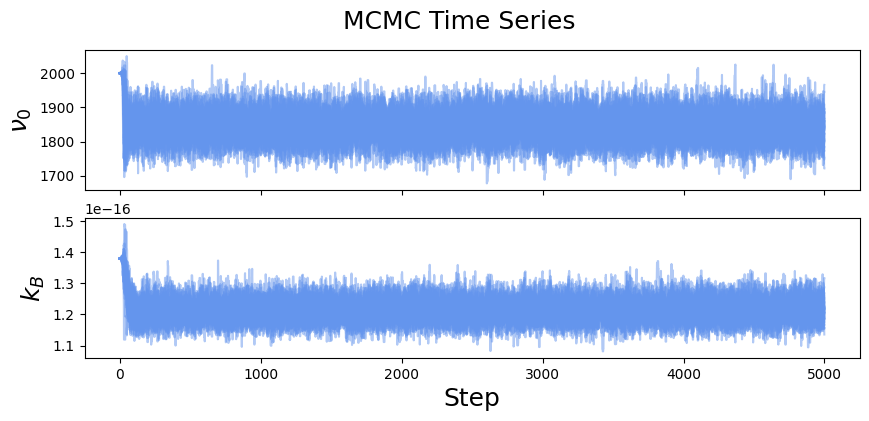

In [3]:
## Plotting the time series. 

fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
labels = [r"$\nu_0$", r"$k_B$"]
for i in range(ndim):
    axes[i].plot(sampler.get_chain()[:, :, i], alpha=0.5,color='cornflowerblue')
    axes[i].set_ylabel(labels[i],fontsize=18)
axes[-1].set_xlabel("Step",fontsize=18)
plt.suptitle("MCMC Time Series",fontsize=18)


*b).* Now, we wish to compute the autocorrelation time $\tau$ of the MCMC samples and plot the autocorrelation function. We then discard the burn-in steps in the MCMC and thin the chain, which can be half the autocorrelation time.

Autocorrelation times: τ_nu0 = 33.0, τ_kB = 32.2
Burn-in: 164 steps, Thinning: every 16 steps


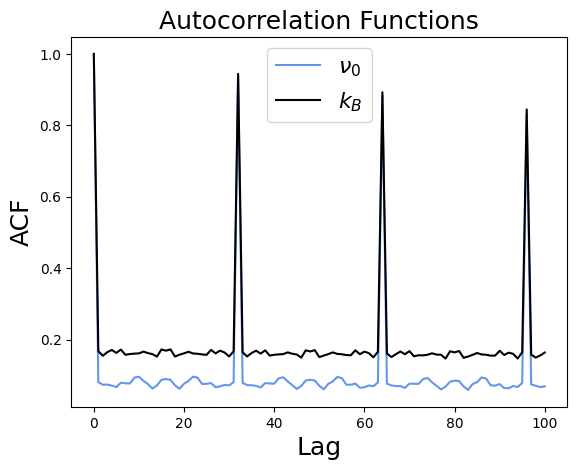

In [4]:
# 2b: The autocorrelation time
## Very convenient that emcee has an autocorrelation method...
tau = sampler.get_autocorr_time(tol=0)

## Discarding burn-in steps and thinning the chain.
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.max(tau))

## Updating the samples.
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

print(f"Autocorrelation times: τ_nu0 = {tau[0]:.1f}, τ_kB = {tau[1]:.1f}")
print(f"Burn-in: {burnin} steps, Thinning: every {thin} steps")

## Define the autocorrelation function
def autocorr(x, max_lag=100):
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full') / np.var(x) / n
    return result[n-1:n+max_lag]

## Find the autocorrelation of each parameter.

acf_nu0 = autocorr(sampler.get_chain(flat=True)[:, 0])
acf_kB = autocorr(sampler.get_chain(flat=True)[:, 1])

plt.plot(acf_nu0, label=r'$\nu_0$',color='cornflowerblue')
plt.plot(acf_kB, label=r'$k_B$',color='k')
plt.title("Autocorrelation Functions",fontsize=18)
plt.xlabel("Lag",fontsize=18)
plt.ylabel("ACF",fontsize=18)
plt.legend(fontsize=16)



*c).* Now, we wish to make a corner plot of of our post burn-in samples and comment on correlations between $v_0$ and $k_B$. We want to estimate the maximum a posteriori values of the parameters from the mode of the distribution, as well as the central 68% CI. Below, I have plotted the corners with the MAP and the 68% CIs.

ν₀ = 1.844e+03 (+4.0e+01, -4.0e+01)
k_B = 1.212e-16 (+3.4e-18, -3.2e-18)


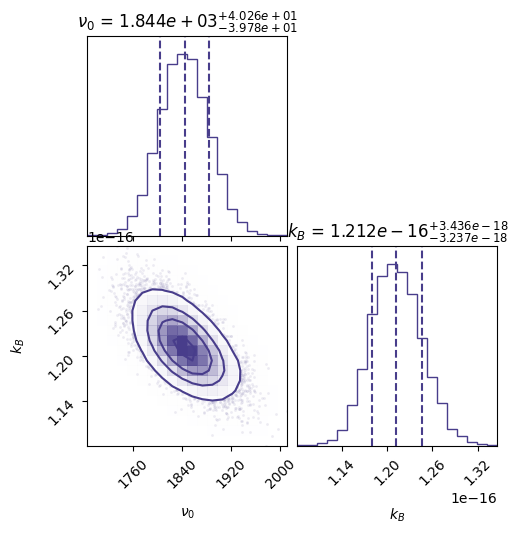

In [5]:
# 2c: Corner plots

## Find and print quantiles for easier reading.
def summary(samples, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    print(f"{name} = {q50:.3e} (+{q84 - q50:.1e}, -{q50 - q16:.1e})")

summary(flat_samples[:, 0], "ν₀")
summary(flat_samples[:, 1], "k_B")


## Plot the corner
fig = corner.corner(flat_samples, labels=[r"$\nu_0$", r"$k_B$"],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_fmt=".3e", title_kwargs={"fontsize": 12},smooth=True,color='darkslateblue')
plt.show()


We see that the marginal posterior distributions of $\nu_0$  and $k_B$​ are both approximately Gaussian above. However, the joint distribution exhibits a weak negative correlation between the two parameters. This is physically sensible: increasing $k_B$​ reduces the steepness of the exponential decay in $\nu(z)$, which can be partially compensated by increasing $\nu_0$​ to maintain agreement with the observed particle counts. Thus, $k_B$​ and $\nu_0$​ are mildly anti-correlated in the posterior.

*d).* Now, from the MCMC samples for $k_B$, we wish to estimate Avogadro's number using the relation $N_A = R/k_B$ for $R = 8.32 \times 10^{7}$ erg mol $^{-1}$ K$^{-1}$. We wish to compute the MAP and the value of the CI for $N_A$.

The MAP and 68% CI for N_A = 6.864e+23 (+1.9e+22, -1.9e+22)


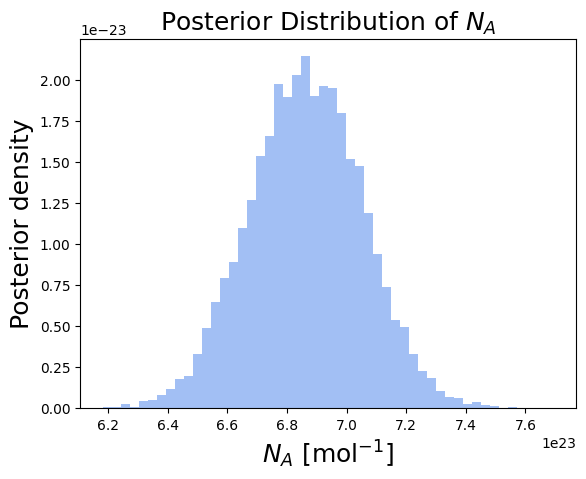

In [6]:
# 2d: Avogadro's Number.

## Define R and extract N_A
R = 8.32e7
NA_samples = R / flat_samples[:, 1]

## Print the MAP and 68% CI.
summary(NA_samples, "The MAP and 68% CI for N_A")

## Plot the histogram.
plt.hist(NA_samples, bins=50, density=True, alpha=0.6,color='cornflowerblue')
plt.xlabel(r"$N_A$ [mol$^{-1}$]", fontsize=18)
plt.ylabel("Posterior density",fontsize=18)
plt.title("Posterior Distribution of $N_A$",fontsize=18);

*e).* Now, we wish to regenerate the MCMC sample using a numiform prior on $\eta_0$ but this time Jeffrey's Prior for $k_B$. We wish to see if the results change significantly.

In [7]:
# 2e: Jeffrey's Prior

## Define the ln prior for Jeffrey's.
def log_prior_jeffreys(theta):
    nu0, kB = theta
    if 1000 < nu0 < 3000 and 1e-17 < kB < 5e-16:
        return -np.log(kB)
    return -np.inf

## Redefine the log posterior for uniform in eta and Jeffrey in kB.
def log_posterior_jeffreys(theta):
    return log_prior_jeffreys(theta) + log_likelihood(theta)

sampler_jeff = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jeffreys)
sampler_jeff.run_mcmc(p0, nsteps, progress=True)

flat_samples_jeff = sampler_jeff.get_chain(discard=burnin, thin=thin, flat=True)

## Print the MAP and CIs
kB_jeff = flat_samples_jeff[:, 1]
q16, q50, q84 = np.percentile(kB_jeff, [16, 50, 84])
print(f"k_B (Jeffreys prior) MAP = {q50:.4e}, 68% CI: ({q16:.4e}, {q84:.4e})")



100%|██████████| 5000/5000 [00:04<00:00, 1140.95it/s]

k_B (Jeffreys prior) MAP = 1.2118e-16, 68% CI: (1.1785e-16, 1.2457e-16)


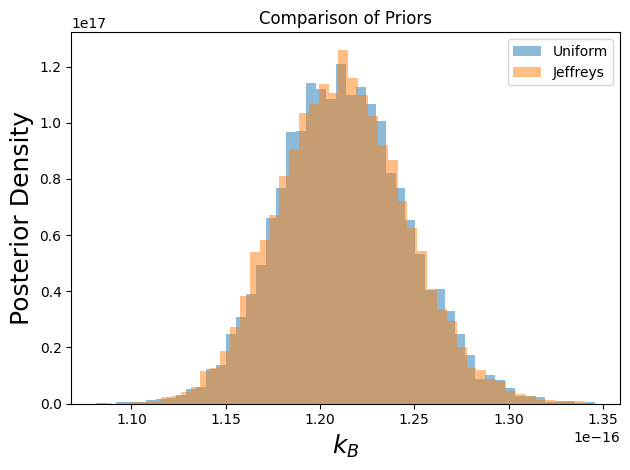

In [8]:
## Plot the two different posteriors for each prior

plt.hist(flat_samples[:, 1], bins=50, density=True, alpha=0.5, label="Uniform")
plt.hist(flat_samples_jeff[:, 1], bins=50, density=True, alpha=0.5, label="Jeffreys")
plt.xlabel(r"$k_B$",fontsize=18)
plt.ylabel(r"Posterior Density",fontsize=18)
plt.title("Comparison of Priors")
plt.legend()
plt.tight_layout()
plt.show()

The results barely change between the two priors. Jeffrey's prior favors smaller values of $k_B$, and we see that indeed it is very slightly less than the uniform case. Since $\nu(z)$ is sharply peaked exponential, it is highly sensitive to a small change in $k_B$. This means that small changes in the prior do not effect the posterior very much.

*f).* Lastly, we wish to look at how the estimate we obtain for $N_A$ differs from the CODATA standard value and if the difference is statistically significant. If so, we wish to comment on systematics.

The CODATA value for $N_A$ is : $6.02214076\times 10^{23}$. So, 

In [9]:
# 2f: Comparison to CODATA for N_A.

NA_codata = 6.02214076e23
NA_mean = np.mean(NA_samples)
NA_std = np.std(NA_samples)

## Convert difference to sigma
n_sigma = abs(NA_mean - NA_codata) / NA_std

print(f"Estimated N_A: {NA_mean:.4e} ± {NA_std:.2e} (1σ)")
print(f"CODATA N_A:    {NA_codata:.4e}")
print(f"Difference from CODATA: {n_sigma:.2f} standard deviations")

Estimated N_A: 6.8644e+23 ± 1.91e+22 (1σ)
CODATA N_A:    6.0221e+23
Difference from CODATA: 4.41 standard deviations


Clearly, this is statistically significant! Since this experiment was done over 100 years ago, Perrin lacked the modern precision of our experiments. To list a few systematics: He only took a few data points. More data may have altered the value we extract for $N_A$. He was likely not able to accurately control temperature fluctuations or measure $T$ precisely. Another reeason could be that the actual microscopy experiment was not precise, since it used knobs (presumably) since this was before the advent of using electronics to precisely and consistently move stages.